### Header Code

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Audio
sound_file = 'C:/Users/austi/Documents/Github_Repos/AutoLoan_BigData/BigDataAnalysis/New_Multi_Dimensional_Analaysis/CongaGroove-mono.wav'

In [302]:
%matplotlib notebook
import os
import plotly
import colorlover as cl
from IPython.display import HTML
import plotly.io as pio
pio.renderers.default = "browser"
import chart_studio.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import scikitplot as skplt
from plotly import tools
import pandas as pd
import random
import numpy as np
import difflib
import pandas_profiling
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
import pylab as pl
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
from scipy import stats
from plotly.subplots import make_subplots
import pickle
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
pd.set_option('display.max_columns', 100)

#data_dict_path = 'C:/Users/austi/Documents/Github_Repos/Imperial_Applied_Project/Detroit/Saved_Data/Test_Data_Dict/'
#saved_data_html_path = 'C:/Users/austi/Documents/Github_Repos/Imperial_Applied_Project/Detroit/Saved_Data/HTML/'


pkl_dataframes_path = 'C:/Users/austi/Documents/Github_Repos/Imperial_Applied_Project/Detroit/Saved_Data/Pickle_DataFrames/'
pkl_file_name = 'Fully_Cleaned_House_Data_8.27.2019.pkl'
os.chdir(pkl_dataframes_path)
#pd.DataFrame.to_csv(data, path_or_buf= csv_data_path + file_name)
data = pd.read_pickle(pkl_dataframes_path+pkl_file_name)

# Save Zestimate as a hold out for final benchmark testing
zestimate_values = data.Zestimate

## Functions

In [268]:
def get_categoryCodes(data, cat_col_list):
    temp = pd.DataFrame(data=None, index=data.index)
    for col in cat_col_list:
        temp_series = data[col].cat.codes
        temp_col = pd.DataFrame(temp_series.values, index=temp_series.index, columns=[str(col) + '_code'])
        temp = pd.concat([temp, temp_col], axis=1)
    return temp

def get_sel_predictedData(model, X_data, Y_data):
    class_probability = model.estimator_.predict_proba(X_data)
    class_names = model.estimator_.classes_
    defaulted_location = list(model.estimator_.classes_).index(1)
    paid_down_location =  list(model.estimator_.classes_).index(0)
    
    default_proba = class_probability[:, defaulted_location]
    paid_down_proba = class_probability[:, paid_down_location]
    fitted_classification = model.estimator_.predict(X_data)
    
    X_data['paid_down_proba'] = paid_down_proba
    X_data['defaulted_proba'] = default_proba
    X_data['paid_down_proba'] = paid_down_proba
    X_data['predicted_ZBC'] = fitted_classification
    X_data['true_ZBC'] = Y_data
    return X_data

def get_predictedData(model, X_data, Y_data):
    class_probability = model.predict_proba(X_data)
    class_names = model.classes_
    defaulted_location = list(model.classes_).index(1)
    paid_down_location =  list(model.classes_).index(0)
    
    default_proba = class_probability[:, defaulted_location]
    paid_down_proba = class_probability[:, paid_down_location]
    fitted_classification = model.predict(X_data)
    
    X_data['paid_down_proba'] = paid_down_proba
    X_data['defaulted_proba'] = default_proba
    X_data['paid_down_proba'] = paid_down_proba
    X_data['predicted_ZBC'] = fitted_classification
    X_data['true_ZBC'] = Y_data
    return X_data

def get_confusionDataDict(predicted_data):
    data_dict = {}
    true_positive = predicted_data[(predicted_data.predicted_ZBC == 1) & (predicted_data.true_ZBC == 1)]
    true_negative = predicted_data[(predicted_data.predicted_ZBC == 0) & (predicted_data.true_ZBC == 0)]
    false_positive = predicted_data[(predicted_data.predicted_ZBC == 1) & (predicted_data.true_ZBC == 0)]
    false_negative = predicted_data[(predicted_data.predicted_ZBC == 0) & (predicted_data.true_ZBC == 1)]
    
    data_dict.update({
        'True_Positive': true_positive,
        'True_Negative': true_negative,
        'False_Positive': false_positive,
        'False_Negative': false_negative
    })
    
    return data_dict

def drop_correlatedCols(data, drop_cols):
    data = data.drop(labels=drop_cols, axis=1)
    
    if KeyError:
        print('Key Error: Columns do not exist')
        return data
    else:
        return data

def dummy_variables(data_col, col_name):
    new_col_names = []
    data_col = pd.get_dummies(data_col)
    for item in list(data_col.columns):
        new_col_names.append(str(col_name) + '_'+ str(item))
    data_col.columns = new_col_names
    return data_col

def standardize_variables(data, col_list):
    data = data[col_list]
    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_values = scaler.fit_transform(data)
    data.loc[:,:] = scaled_values
    return data_dict

def get_cross_validate_rfr(x, y, estimator_numbers, show_chart):
    mean = []
    std_upper = []
    std_lower = []
    r_squared = []
    feature_dict = {}
    for est in estimator_numbers:
        model = rfr(n_estimators=est, max_depth=None)
        scores = cross_val_score(model, X=x, y=y, cv=10, scoring='explained_variance')
        model.fit(X=x, y=y)
        feature_importance = sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), list(x.columns)), reverse=True)
        feature_importance_df = pd.DataFrame(feature_importance, columns=['Percent', 'Feature'])
        feature_dict[f'Num_Est_{est}'] = feature_importance_df
        
        print(f'Estimators: {est}')
        r_squared_score = model.score(x, y)
        r_squared.append(r_squared_score)
        print(f'Model R^2 Score: {r_squared_score}')
        
        print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), '\n')

        mean.append(scores.mean())
        std_upper.append(scores.mean()+scores.std()*2)
        std_lower.append(scores.mean()-scores.std()*2)
    display(pd.concat(feature_dict, axis=1))
    # Ask to save down the dataframe as a csv or pkl file
    chart_fig = plot_explained_variance(estimator_numbers, mean_score=mean, upper_std=std_upper, lower_std=std_lower, show_fig=show_chart)

def get_pdpDict(estimator, X):
    pdp_list = []
    pdp_data_dict = {}
    for i in range(0, len(X.columns)):
        pdp_list.append(partial_dependence(estimator, X, features=[i]))
    for i in range(0, len(X.columns)):
        col_name = X.columns[i]
        pdp_data_dict.update({col_name: {}})
        pdp_data_dict[col_name].update({
            'yaxis': np.exp(pdp_list[i][0][0]),
            'xaxis': pdp_list[i][1][0]
        })
    f = open("PDP_Data_Dict.pkl", "wb")
    pickle.dump(pdp_data_dict, f)
    f.close()
    return pdp_data_dict

def get_pdpTextCategory(data_dict, data_cat_cols):
    data_dict = data_dict.copy()
    category_dict_map = {}
    data_cat_cols.apply(lambda x: category_dict_map.update({str(x.name + '_code') : dict(enumerate(x.cat.categories))}))
    
    for col in data_dict.keys():
        if col in ['Structure_Type_Cat_code', 'Store_Name_code']:
            continue
        code_label_lis = []
        if col not in category_dict_map.keys():
            continue
        for code in data_dict[col]['xaxis']:
            code_label_lis.append(category_dict_map[col][code])
        data_dict[col]['xaxis'] = code_label_lis
    return data_dict

def load_Dictionary(path, file_name):
    with open(path + str(file_name), "rb") as input_file:
        data_dict = pickle.load(input_file)
    return data_dict

#### Chart Function:

In [4]:
def plot_explained_variance(estimator_num, mean_score, upper_std, lower_std, show_fig):
    if show_fig:
        chart_title = input('Input Chart Title: ')
    else:
        chart_title = 'Number of Tree Estimators vs Explained Variance'
    
    upper_bound = go.Scatter(
    name='Upper Bound',
    x=estimator_num,
    y=upper_std,
    mode='lines',
    marker=dict(color="#444"),
    line=dict(width=0),
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty')

    trace = go.Scatter(
        name='Measurement',
        x=estimator_num,
        y=mean_score,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    lower_bound = go.Scatter(
        name='Lower Bound',
        x=estimator_num,
        y=lower_std,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines')

    # Trace order can be important
    # with continuous error bars
    data = [lower_bound, trace, upper_bound]

    layout = go.Layout(
        yaxis=dict(title='Cross Validated, fold: 10 Explained Variance Average', range=[0, 1]),
        xaxis=dict(title='Number of Tree Estimators'),
        title=f'Number of Estimators vs Average Explained variance: {chart_title}',
        showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    if show_fig:
        return fig.show()
    else:
        return fig
    


## Cleaning Data

In [23]:
data.Saves = pd.to_numeric(data.Saves, errors='corece').fillna(0)
data.Views = pd.to_numeric(data.Views, errors='corece').fillna(0)
data = data.drop(['Address', 'Zestimate'], axis=1)

##### Log Normal Price Transofrmation

<IPython.core.display.Javascript object>


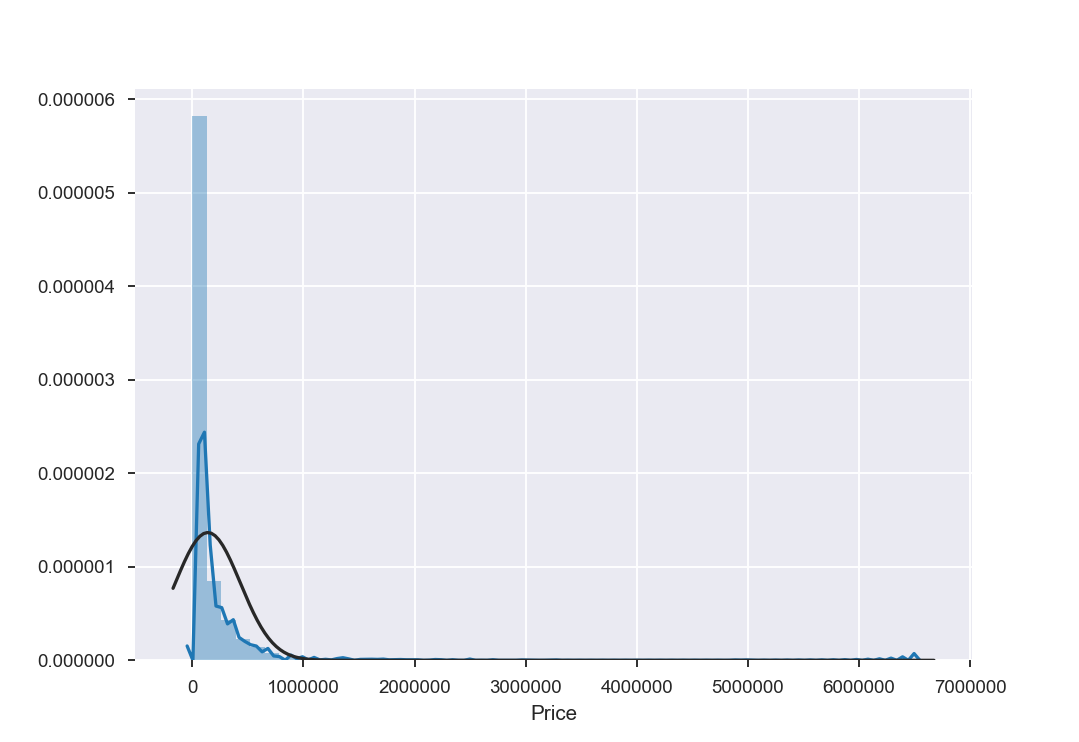

C:\Users\austi\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



<IPython.core.display.Javascript object>


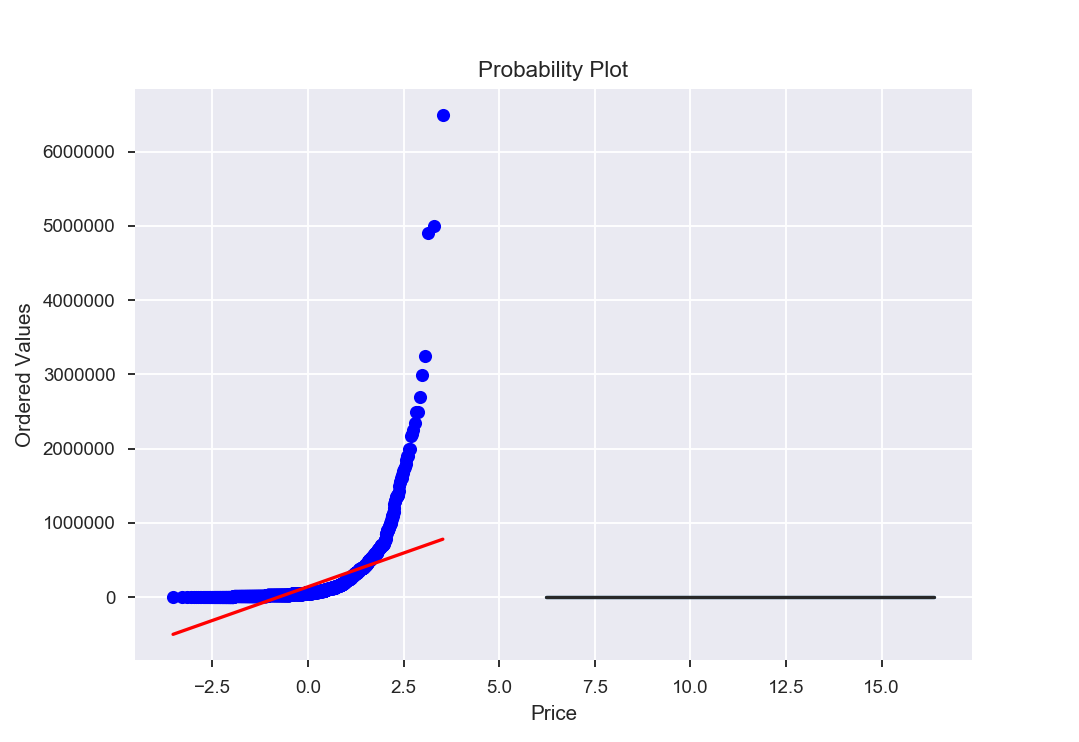

In [24]:
from scipy.stats import norm
sns.distplot(data.Price[data.Price.notna()],fit=norm);
fig = plt.figure()
res = stats.probplot(data.Price[data.Price.notna()], plot=plt)

<IPython.core.display.Javascript object>


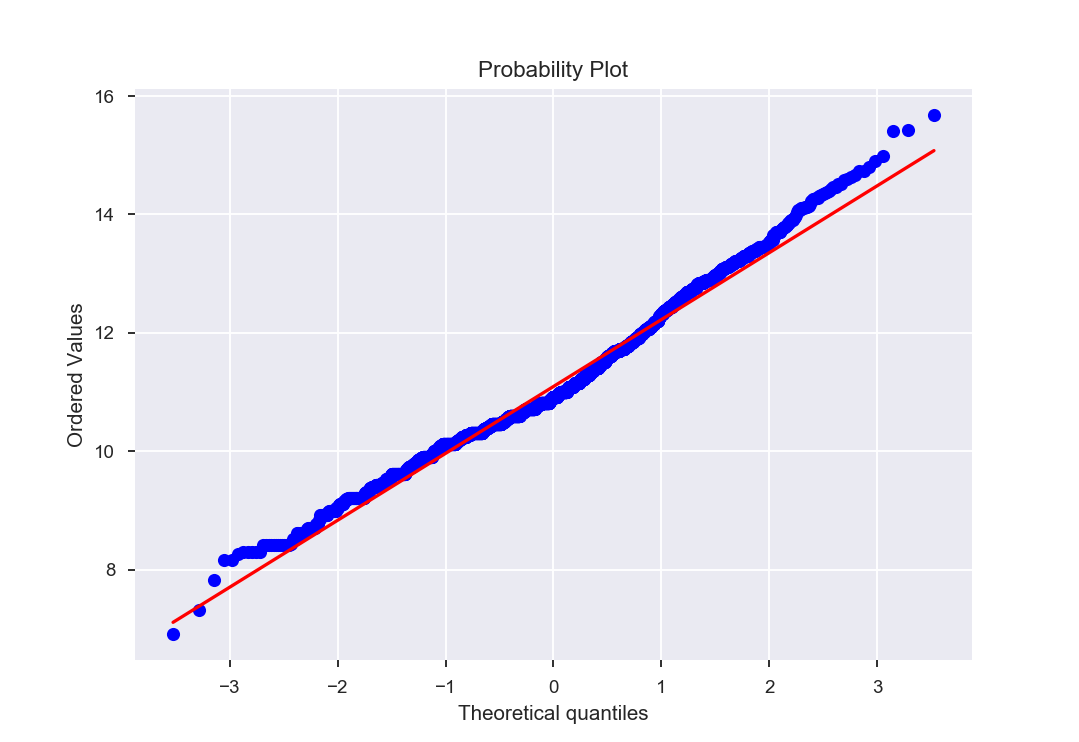

In [25]:
data.Price = np.log(data.Price[data.Price.notna()])
sns.distplot(data.Price,fit=norm);
fig = plt.figure()
res = stats.probplot(data.Price, plot=plt)

##### Transform Categories into Cat Codes & Remove Category Columns

In [26]:
cat_cols = [
    'Parking_Features_Cat',
    'Heating_Cat',
    'Cooling_Cat',
    'Basement_Cat',
    'Roof_Cat',
    'Structure_Type_Cat',
    'Construction_Materials_Cat',
    'Exterior_Features_Cat',
    'Architectural_Style_Cat',
    'Home_Type',
    'Store_Name',
    #Zip_Code
]

category_codes = get_categoryCodes(data=data, cat_col_list=cat_cols)
temp = data.drop(cat_cols, axis=1)
temp = temp.merge(category_codes, left_index=True, right_index=True)

## Loading Data and Models

### Main Code

#### Correlation Matrix

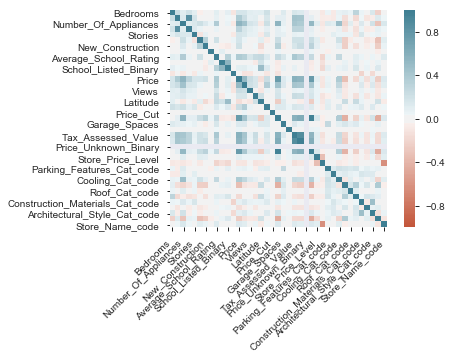

In [133]:
corr = temp.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [89]:
#Bathrooms and total interior living area is highly correlated
corr[(np.absolute(corr*100) > 70)]

,Bedrooms,Total_Interior_Livable_Area,Number_Of_Appliances,Bathrooms,Stories,Year_Built,New_Construction,Hoa_Fee,Average_School_Rating,Average_School_Distance,...,Heating_Cat_code,Cooling_Cat_code,Basement_Cat_code,Roof_Cat_code,Structure_Type_Cat_code,Construction_Materials_Cat_code,Exterior_Features_Cat_code,Architectural_Style_Cat_code,Home_Type_code,Store_Name_code
Bedrooms,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total_Interior_Livable_Area,NaN,1.00000,NaN,0.85404,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number_Of_Appliances,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bathrooms,NaN,0.85404,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stories,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year_Built,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
New_Construction,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hoa_Fee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average_School_Rating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average_School_Distance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Random Forest

In [27]:
# Dropping Values that are extremely Realted to Price
temp = temp.drop(['Calculated_Price_Sqft', 'Price_sqft'], axis=1)
#temp = temp.drop(['Tax_Assessed_Value', 'Annual_Tax_Amount'], axis=1)

##### Train Test Split

In [28]:
model_df = temp
from sklearn.ensemble import RandomForestRegressor as rfr
y = model_df.Price
x = model_df.drop('Price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
display(list(model_df.columns))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

['Bedrooms',
 'Total_Interior_Livable_Area',
 'Number_Of_Appliances',
 'Bathrooms',
 'Stories',
 'Year_Built',
 'New_Construction',
 'Hoa_Fee',
 'Average_School_Rating',
 'Average_School_Distance',
 'School_Listed_Binary',
 'Time_On_Zillow',
 'Price',
 'Number_Of_Photos',
 'Views',
 'Longitude',
 'Latitude',
 'Saves',
 'Price_Cut',
 'Garage_Spaces',
 'Lot_Size',
 'Tax_Assessed_Value',
 'Annual_Tax_Amount',
 'Price_Unknown_Binary',
 'Store_Price_Level',
 'Store_Listed_Binary',
 'Zip_Code',
 'Parking_Features_Cat_code',
 'Heating_Cat_code',
 'Cooling_Cat_code',
 'Basement_Cat_code',
 'Roof_Cat_code',
 'Structure_Type_Cat_code',
 'Construction_Materials_Cat_code',
 'Exterior_Features_Cat_code',
 'Architectural_Style_Cat_code',
 'Home_Type_code',
 'Store_Name_code']

(2312, 37) (2312,)
(992, 37) (992,)


##### Best Estimator Number

In [41]:
# Including Tax Info which is related to price
get_cross_validate_rfr(x=X_train, y=y_train, estimator_numbers=[2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120], show_chart=True)

Estimators: 2
Est. explained variance: 0.64 (+/- 0.09) 

Estimators: 5
Est. explained variance: 0.73 (+/- 0.09) 

Estimators: 10
Est. explained variance: 0.76 (+/- 0.06) 

Estimators: 20
Est. explained variance: 0.77 (+/- 0.06) 

Estimators: 30
Est. explained variance: 0.78 (+/- 0.06) 

Estimators: 40
Est. explained variance: 0.78 (+/- 0.06) 

Estimators: 50
Est. explained variance: 0.78 (+/- 0.07) 

Estimators: 60
Est. explained variance: 0.78 (+/- 0.06) 

Estimators: 70
Est. explained variance: 0.78 (+/- 0.06) 

Estimators: 80
Est. explained variance: 0.78 (+/- 0.06) 

Estimators: 90
Est. explained variance: 0.78 (+/- 0.06) 

Estimators: 100
Est. explained variance: 0.79 (+/- 0.06) 

Estimators: 120
Est. explained variance: 0.79 (+/- 0.06) 



Num_Est_10                                  Num_Est_100  \
      Percent                          Feature     Percent   
0      0.5637               Tax_Assessed_Value      0.5700   
1      0.1012                Annual_Tax_Amount      0.0928   
2      0.0471             Number_Of_Appliances      0.0496   
3      0.0391      Total_Interior_Livable_Area      0.0353   
4      0.0319                 Number_Of_Photos      0.0298   
5      0.0303                       Year_Built      0.0249   
6      0.0181                   Time_On_Zillow      0.0237   
7      0.0178                            Views      0.0196   
8      0.0177                        Longitude      0.0188   
9      0.0167                        Bathrooms      0.0184   
10     0.0158                         Latitude      0.0177   
11     0.0135                            Saves      0.0156   
12     0.0122                         Zip_Code      0.0125   
13     0.0103                         Lot_Size      0.0092   
14     0.0067     Architectural_Style_Cat_code      0.0068   
15     0.0065          Average_School_Distance      0.0066   
16     0.0054                         Bedrooms      0.0060   
17     0.0053          Structure_Type_Cat_code      0.0052   
18     0.0044                          Stories      0.0037   
19     0.0041       Exterior_Features_Cat_code      0.0036   
20     0.0041  Construction_Materials_Cat_code      0.0036   
21     0.0037                  Store_Name_code      0.0030   
22     0.0036        Parking_Features_Cat_code      0.0029   
23     0.0031                 Cooling_Cat_code      0.0029   
24     0.0029                        Price_Cut      0.0029   
25     0.0028                Basement_Cat_code      0.0027   
26     0.0022                   Home_Type_code      0.0024   
27     0.0022                    Garage_Spaces      0.0022   
28     0.0018                          Hoa_Fee      0.0021   
29     0.0015                    Roof_Cat_code      0.0012   
30     0.0014                 Heating_Cat_code      0.0011   
31     0.0011             School_Listed_Binary      0.0010   
32     0.0009              Store_Listed_Binary      0.0009   
33     0.0008                Store_Price_Level      0.0008   
34     0.0002            Average_School_Rating      0.0003   
35     0.0000             Price_Unknown_Binary      0.0000   
36     0.0000                 New_Construction      0.0000   

                                    Num_Est_120  \
                            Feature     Percent   
0                Tax_Assessed_Value      0.5659   
1                 Annual_Tax_Amount      0.1004   
2              Number_Of_Appliances      0.0524   
3       Total_Interior_Livable_Area      0.0341   
4                         Bathrooms      0.0272   
5                  Number_Of_Photos      0.0247   
6                        Year_Built      0.0218   
7                    Time_On_Zillow      0.0190   
8                         Longitude      0.0190   
9                             Views      0.0184   
10                         Latitude      0.0184   
11                         Zip_Code      0.0151   
12                            Saves      0.0122   
13                         Lot_Size      0.0094   
14          Average_School_Distance      0.0070   
15                         Bedrooms      0.0059   
16          Structure_Type_Cat_code      0.0053   
17     Architectural_Style_Cat_code      0.0045   
18       Exterior_Features_Cat_code      0.0040   
19                          Stories      0.0039   
20                  Store_Name_code      0.0036   
21                        Price_Cut      0.0034   
22        Parking_Features_Cat_code      0.0031   
23                 Cooling_Cat_code      0.0030   
24  Construction_Materials_Cat_code      0.0029   
25                Basement_Cat_code      0.0028   
26                    Garage_Spaces      0.0023   
27                    Roof_Cat_code      0.0021   
28                          Hoa_Fee      0.0017   
29 

Input Chart Title: Includes Tax Features


In [29]:
# Removed Tax Features which are closely tied to the Price Feature
model_df_update = model_df.drop(['Tax_Assessed_Value', 'Annual_Tax_Amount'], axis=1)
y = model_df_update.Price
x = model_df_update.drop('Price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [48]:
get_cross_validate_rfr(x=X_train, y=y_train, estimator_numbers=[2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120], show_chart=True)

Estimators: 2
Model R^2 Score: 0.8599902675075877
Est. explained variance: 0.56 (+/- 0.13) 

Estimators: 5
Model R^2 Score: 0.9252099214408265
Est. explained variance: 0.65 (+/- 0.08) 

Estimators: 10
Model R^2 Score: 0.9473799491182089
Est. explained variance: 0.69 (+/- 0.07) 

Estimators: 20
Model R^2 Score: 0.9515284148065971
Est. explained variance: 0.70 (+/- 0.05) 

Estimators: 30
Model R^2 Score: 0.9561359556203406
Est. explained variance: 0.71 (+/- 0.05) 

Estimators: 40
Model R^2 Score: 0.9566803195088981
Est. explained variance: 0.71 (+/- 0.06) 

Estimators: 50
Model R^2 Score: 0.9593679951262517
Est. explained variance: 0.72 (+/- 0.07) 

Estimators: 60
Model R^2 Score: 0.9608261124912231
Est. explained variance: 0.72 (+/- 0.06) 

Estimators: 70
Model R^2 Score: 0.9614052535419911
Est. explained variance: 0.72 (+/- 0.06) 

Estimators: 80
Model R^2 Score: 0.9600096093737149
Est. explained variance: 0.72 (+/- 0.06) 

Estimators: 90
Model R^2 Score: 0.9609469698587
Est. explained

Num_Est_10                                  Num_Est_100  \
      Percent                          Feature     Percent   
0      0.2975             Number_Of_Appliances      0.2854   
1      0.1594      Total_Interior_Livable_Area      0.1492   
2      0.0838                        Bathrooms      0.0994   
3      0.0504                        Longitude      0.0469   
4      0.0416                       Year_Built      0.0418   
5      0.0360                 Number_Of_Photos      0.0418   
6      0.0340                         Lot_Size      0.0357   
7      0.0293                            Views      0.0313   
8      0.0264                         Latitude      0.0259   
9      0.0238                   Home_Type_code      0.0244   
10     0.0217                   Time_On_Zillow      0.0239   
11     0.0208                         Zip_Code      0.0239   
12     0.0197                            Saves      0.0225   
13     0.0157            Average_School_Rating      0.0180   
14     0.0148                Basement_Cat_code      0.0151   
15     0.0138                    Roof_Cat_code      0.0119   
16     0.0111                          Hoa_Fee      0.0106   
17     0.0107                          Stories      0.0096   
18     0.0106                 Cooling_Cat_code      0.0092   
19     0.0091                         Bedrooms      0.0088   
20     0.0087     Architectural_Style_Cat_code      0.0072   
21     0.0085          Average_School_Distance      0.0069   
22     0.0072                 Heating_Cat_code      0.0068   
23     0.0065          Structure_Type_Cat_code      0.0067   
24     0.0064        Parking_Features_Cat_code      0.0061   
25     0.0064       Exterior_Features_Cat_code      0.0059   
26     0.0061                  Store_Name_code      0.0052   
27     0.0049                        Price_Cut      0.0051   
28     0.0049                    Garage_Spaces      0.0041   
29     0.0039             School_Listed_Binary      0.0038   
30     0.0033  Construction_Materials_Cat_code      0.0034   
31     0.0015                Store_Price_Level      0.0020   
32     0.0014              Store_Listed_Binary      0.0014   
33     0.0001                 New_Construction      0.0001   
34     0.0000             Price_Unknown_Binary      0.0000   

                                    Num_Est_120  \
                            Feature     Percent   
0              Number_Of_Appliances      0.2842   
1       Total_Interior_Livable_Area      0.1388   
2                         Bathrooms      0.1085   
3                         Longitude      0.0471   
4                        Year_Built      0.0423   
5                          Lot_Size      0.0420   
6                  Number_Of_Photos      0.0333   
7                             Views      0.0305   
8                          Latitude      0.0256   
9                    Time_On_Zillow      0.0254   
10                         Zip_Code      0.0236   
11                   Home_Type_code      0.0229   
12                            Saves      0.0218   
13            Average_School_Rating      0.0197   
14                Basement_Cat_code      0.0152   
15                          Hoa_Fee      0.0118   
16                    Roof_Cat_code      0.0116   
17          Average_School_Distance      0.0109   
18                 Cooling_Cat_code      0.0087   
19                          Stories      0.0081   
20                  Store_Name_code      0.0079   
21          Structure_Type_Cat_code      0.0074   
22                         Bedrooms      0.0073   
23        Parking_Features_Cat_code      0.0071   
24       Exterior_Features_Cat_code      0.0068   
25     Architectural_Style_Cat_code      0.0064   
26                        Price_Cut      0.0055   
27                 Heating_Cat_code      0.0044   
28  Construction_Materials_Cat_code      0.0041   
29                    Garage_Spaces      0.0039   
30             School_Listed_Binary      0.0038   
31                Store_P

Input Chart Title: Removed Tax Features


##### Randomized Grid Search for Hyperparameter Selection

In [26]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_model = rfr()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfr_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
 '''
 Best Parameters Based on Randomized Grid Search:
 {'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}
 
 '''
display(rfr_random.fit(X_train, y_train))
print(sorted(zip(map(lambda x: round(x, 4), rfr_random.estimator.feature_importances_), list(x.columns)), reverse=True))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 41.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


##### MIR Results

In [12]:
import sklearn.feature_selection as fs
features_used = X_train.columns

mir_result = fs.mutual_info_regression(X_train, y_train) # mutual information regression feature ordering
feature_scores = []
for i in np.arange(len(features_used)):
    feature_scores.append([features_used[i],mir_result[i]])
sorted_scores = sorted(np.array(feature_scores), key=lambda s: float(s[1]), reverse=True) 
print(np.array(sorted_scores))
top_mir_values = list(np.array(sorted_scores)[0:20, 0])

[['Zip_Code' '0.4422524042734475']
 ['Longitude' '0.359609946032343']
 ['Total_Interior_Livable_Area' '0.24975540664901752']
 ['Average_School_Rating' '0.21635093086928014']
 ['Bathrooms' '0.21433363551392404']
 ['Views' '0.2007832128542555']
 ['Number_Of_Appliances' '0.1995865775652126']
 ['Number_Of_Photos' '0.18384603456402937']
 ['Structure_Type_Cat_code' '0.1803479476421268']
 ['Year_Built' '0.17889741087894073']
 ['Lot_Size' '0.17022386329709027']
 ['Time_On_Zillow' '0.14799179084877956']
 ['Architectural_Style_Cat_code' '0.1438750781181084']
 ['Latitude' '0.13575814397580377']
 ['Bedrooms' '0.11877871180300215']
 ['Price_Cut' '0.11116408708150782']
 ['Store_Name_code' '0.10823220308232795']
 ['Cooling_Cat_code' '0.10645705689888829']
 ['Basement_Cat_code' '0.099277288896374']
 ['Average_School_Distance' '0.09029075706660539']
 ['Stories' '0.0902178329355201']
 ['Roof_Cat_code' '0.0871721856698986']
 ['Saves' '0.08119742386260054']
 ['Hoa_Fee' '0.07740242124202834']
 ['Constructi

##### Re-Modeling After MIR Results

In [31]:
model = rfr(n_estimators=400, max_depth=None, max_features='sqrt', bootstrap=False)
model.fit(X=X_train[top_mir_values], y=y_train)
print(sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), list(X_train[top_mir_values].columns)), reverse=True))
pred_values = model.predict(X_test[top_mir_values])

[(0.1361, 'Number_Of_Appliances'), (0.114, 'Total_Interior_Livable_Area'), (0.1115, 'Bathrooms'), (0.09, 'Number_Of_Photos'), (0.0733, 'Longitude'), (0.0584, 'Lot_Size'), (0.0512, 'Year_Built'), (0.0434, 'Latitude'), (0.0427, 'Zip_Code'), (0.0408, 'Views'), (0.0407, 'Basement_Cat_code'), (0.0382, 'Cooling_Cat_code'), (0.0324, 'Time_On_Zillow'), (0.0233, 'Average_School_Rating'), (0.0221, 'Structure_Type_Cat_code'), (0.0202, 'Bedrooms'), (0.0181, 'Average_School_Distance'), (0.0166, 'Store_Name_code'), (0.0148, 'Architectural_Style_Cat_code'), (0.0122, 'Price_Cut')]


In [101]:
print(sklearn.metrics.explained_variance_score(y_true=y_test, y_pred=pred_values))
print(sklearn.metrics.mean_absolute_error(y_true=y_test, y_pred=pred_values))

0.7680872195899797
0.3969194502651106


##### Prediction vs True vs Zestimate Cleaning

In [92]:
prices_df = pd.DataFrame({'True_Prices': np.exp(y_test.values),
                          'Zestimate':zestimate_values.loc[y_test.index].values,
                          'Price_True_idx':y_test.index,
                          'Zestimate_idx':zestimate_values.loc[y_test.index].index,})
#prices_df = pd.DataFrame(y_true, index=y_true.index, columns=['True_Prices'])
prices_df = pd.concat([prices_df, pd.DataFrame(np.exp(pred_values), columns=['Pred_Prices'])], axis=1)
prices_df = prices_df.sort_values(by='True_Prices')

In [94]:
score_zestimate_df = prices_df
score_zestimate_df = score_zestimate_df.dropna()

##### Zestimate Comparison

In [109]:
print(f'Number of NaN\'s in Zestimate: {zestimate_values.isna().sum()}\n% Zestimate NaN in Predictions: {round((prices_df.Zestimate.isna().sum())/len(prices_df.index), 2)}')
print(sklearn.metrics.explained_variance_score(y_true=score_zestimate_df.True_Prices, y_pred=score_zestimate_df.Zestimate))
print(sklearn.metrics.mean_absolute_error(y_true=score_zestimate_df.True_Prices, y_pred=score_zestimate_df.Zestimate))
print(sklearn.metrics.mean_squared_error(y_true=score_zestimate_df.True_Prices, y_pred=score_zestimate_df.Zestimate))

Number of NaN's in Zestimate: 1538
% Zestimate NaN in Predictions: 0.47
0.9919273687648312
12757.389413988658
684880174.482042


##### Prediction vs True vs Zestimate Charting

In [100]:
trace_true = go.Scatter(
    name='True',
    x=prices_df.True_Prices,
    mode='markers')

trace_pred = go.Scatter(
    name='Predicted',
    x=prices_df.Pred_Prices,
    mode='markers',
    opacity = 0.7,)

trace_zestimates = go.Scatter(
    name='Zestimate',
    x=prices_df.Zestimate,
    mode='markers',
    opacity = 0.7,)

plot_data = [trace_true, trace_pred, trace_zestimates]

layout = go.Layout(
    yaxis=dict(title='Number of Homes'),
    xaxis=dict(title='Prices', tickformat="$,.2s", range=[0,1200000]),
    title=f'Predicted vs True vs Zestimate Listed Prices',
    showlegend = True,
    legend=dict(x=.375, y=.74)

)
fig = go.Figure(data=plot_data, layout=layout)
fig.show()

##### Partial Dependence Charting

In [110]:
display(list(zip(list(X_train[top_mir_values].columns), range(0, len(X_train[top_mir_values].columns)))))

[('Zip_Code', 0),
 ('Longitude', 1),
 ('Total_Interior_Livable_Area', 2),
 ('Average_School_Rating', 3),
 ('Bathrooms', 4),
 ('Views', 5),
 ('Number_Of_Appliances', 6),
 ('Number_Of_Photos', 7),
 ('Structure_Type_Cat_code', 8),
 ('Year_Built', 9),
 ('Lot_Size', 10),
 ('Time_On_Zillow', 11),
 ('Architectural_Style_Cat_code', 12),
 ('Latitude', 13),
 ('Bedrooms', 14),
 ('Price_Cut', 15),
 ('Store_Name_code', 16),
 ('Cooling_Cat_code', 17),
 ('Basement_Cat_code', 18),
 ('Average_School_Distance', 19)]

In [294]:
def get_pdp_linePlot(x_values, y_values, plot_name):
    pdp_trace = go.Scatter(
        x = x_values,
        y = y_values,
        name = plot_name + 'Partial Dependence',
        mode='lines',
        opacity = 0.7,
    )
    
    layout = go.Layout(
    yaxis=dict(title='Home Price',tickformat="$,.2s"),
    xaxis=dict(title=f'{plot_name}{title_add_on}', tickformat=",.2", ticksuffix=suffix),
    title=f'{plot_name} Partial Dependence Plot',
    showlegend = False,
    )
    fig = go.Figure(data=[pdp_trace], layout=layout)
    return fig.show()

def get_pdp_trace(x_values, y_values, plot_name):
    pdp_trace = go.Scatter(
        x = x_values,
        y = y_values,
        #name = plot_name + 'Partial Dependence',
        mode='lines',
        opacity = 0.7,
    )
    return pdp_trace

def get_all_dpdPlots(data_dict, titles):
    fig = make_subplots(rows=5, cols=4, subplot_titles=title_list)
    

    row_val=1
    col_val=1
    for feat in title_list:
        if col_val > 4:
            col_val=1
            row_val+=1
        #print(f'{feat}: row: {row_val}, col: {col_val}')
        fig.add_trace(get_pdp_trace(data_dict[feat]['xaxis'], data_dict[feat]['yaxis'], plot_name=feat), row=row_val, col=col_val)
        col_val+=1
    row_val=1
    col_val=1
    for feat in title_list:
        x_axis_type = '-'
        x_axis_range = None
        x_tick_format = None
        x_tick_suffix = ''
        x_tickfont = None

        if col_val > 4:
            col_val=1
            row_val+=1
        if feat in ['Structure_Type_Cat_code', 'Architectural_Style_Cat_code', 'Basement_Cat_code', 'Store_Name_code', 'Cooling_Cat_code']:
            x_axis_type = 'category'
            x_tickfont=dict(size=10)
            
        if feat == 'Bathrooms':
            x_axis_range = [0, 10]
        if feat == 'Bedrooms':
            x_axis_range = [0, 15]
        if feat == 'Lot_Size':
            x_tick_format = ".2"
            x_axis_range = [0, 2]
            x_tick_suffix = ' ac.'
        if feat == 'Total_Interior_Livable_Area':
            x_tick_format = ",.2"
            x_tick_suffix = ' sqft'
        if feat == 'Average_School_Distance':
            x_tick_suffix = ' Mi.'
        if feat == 'Price_Cut':
            x_tick_format = "$,.2s"
        if feat in ['Latitude', 'Longitude']:
            x_tick_format = ".6s"

        fig.update_xaxes(range=x_axis_range, tickformat=x_tick_format, ticksuffix=x_tick_suffix, row=row_val, col=col_val, tickfont=x_tickfont, type=x_axis_type)
        fig.update_yaxes(title_text="Home Price", tickformat="$,.2s", row=row_val, col=col_val)
        col_val+=1
    fig.update_layout(showlegend=False, title_text="Partial Dependence Plots")
    return fig

In [178]:
title_list = ('Zip_Code', 'Longitude', 'Total_Interior_Livable_Area', 'Average_School_Rating', 'Bathrooms', 'Views', 'Number_Of_Appliances',
 'Number_Of_Photos', 'Structure_Type_Cat_code', 'Year_Built', 'Lot_Size', 'Time_On_Zillow', 'Architectural_Style_Cat_code',
 'Latitude', 'Bedrooms', 'Price_Cut', 'Store_Name_code', 'Cooling_Cat_code', 'Basement_Cat_code', 'Average_School_Distance')

In [ ]:
pdp_data_dict = load_Dictionary(pkl_dataframes_path, file_name='PDP_Data_Dict.pkl')
test = get_pdpTextCategory(pdp_data_dict, data[cat_cols])

In [300]:
get_all_dpdPlots(test, title_list)